In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import os
import glob
import numpy as np
import pandas as pd

from ragmac_xdem import plotting, utils, files, temporal, io

import warnings
warnings.filterwarnings('ignore')

## Experiment 2
- Process all ASTER dems
- Use outputs from ragmac_xdem/scripts/main_experiment2.py
 - `selection_opts = {"mode": None, }`
 

### In this notebook
- Load and stack DEM arrays
- Manually select points to evaluate linear regression and GPR fits

### Gather files

In [36]:
input_dir = '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs'
dem_files_list = sorted(glob.glob(os.path.join(input_dir, '*.tif')))

### Parse dates

In [37]:
datetimes_list = utils.get_dems_date(dem_files_list)

### Get stacked masked array and dates
- DEMs are already aligned
- Can just stack the numpy arrays with helper function

In [38]:
dates_list = [d.date() for d in datetimes_list]

In [39]:
%%time
ma_stack = io.stack_geotif_arrays(dem_files_list)

CPU times: user 22.3 s, sys: 6 s, total: 28.3 s
Wall time: 34.8 s


### Plot gallery
- quick look

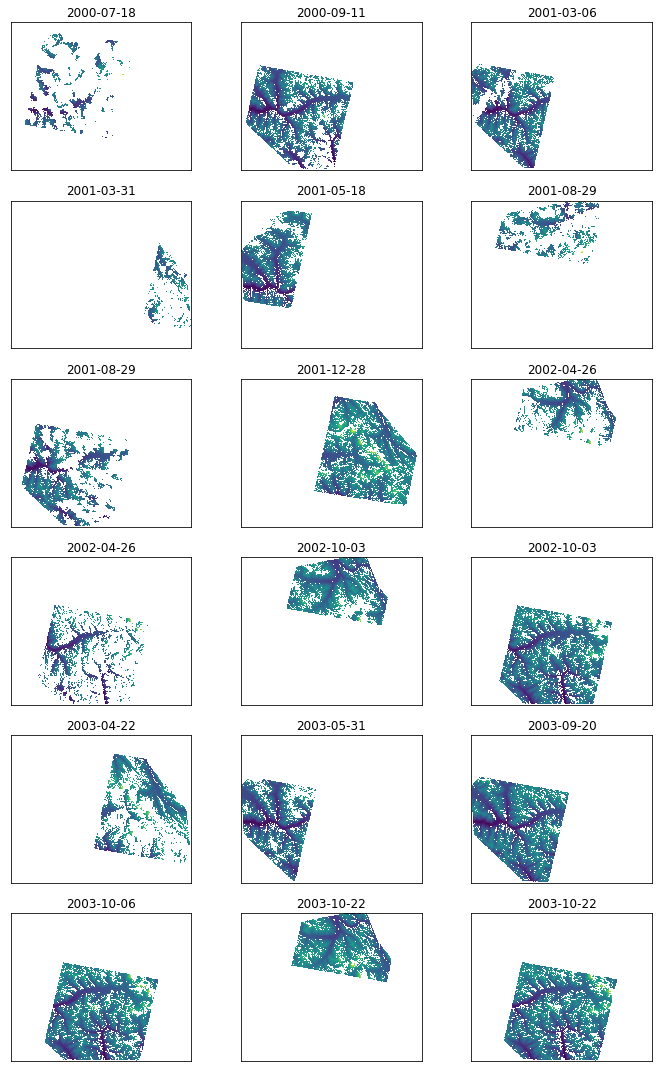

In [40]:
n = 18
plotting.plot_array_gallery(ma_stack[:n], dates_list[:n])

### Create count and STD maps

In [41]:
%%time
count = np.ma.count(ma_stack,axis=0)
count = np.ma.masked_where(count==0,count)
std   = np.ma.std(ma_stack,axis=0)
count_nmad_ma_stack = np.ma.stack([count,std])

CPU times: user 23.1 s, sys: 1min, total: 1min 23s
Wall time: 1min 27s


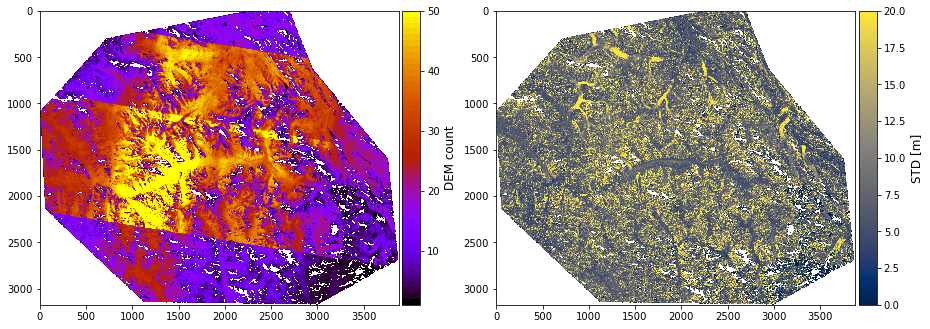

In [42]:
plotting.plot_count_std(count_nmad_ma_stack)

### Select points for testing
- Select points using array coordinates
- Points along primary flowline
- Points randomly selected nearby points

In [43]:
center_flowline_points = ([1000,1300,1650,2000,2300],
                          [1970,1800,1650,1650,1600])
n = 5
points= (np.append(np.random.random_integers(1200,3000,n),center_flowline_points[0]),
         np.append(np.random.random_integers(1000,2500,n),center_flowline_points[1]))

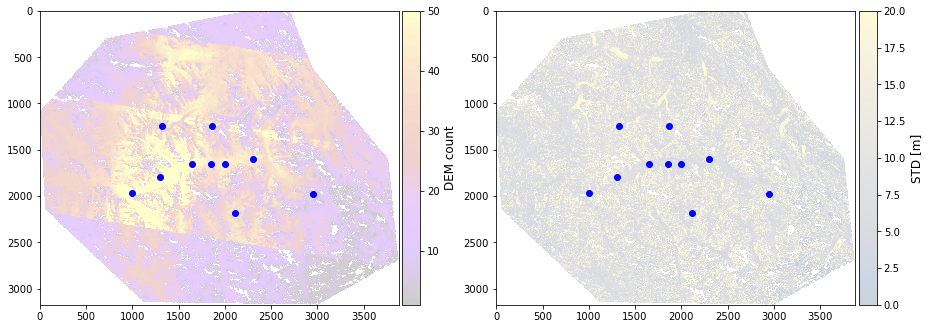

In [44]:
plotting.plot_count_std(count_nmad_ma_stack,points = points,alpha=0.2, ticks_off=False)

In [45]:
# n = 5
# plotting.plot_timelapse(ma_stack[:n], 
#                      points=points, 
#                      titles_list=dates_list,
#                      alpha=0.2)

### Prepare training data

In [46]:
date_time_as_float_array = np.ma.array([utils.date_time_to_decyear(i) for i in datetimes_list]).data
test_stack = ma_stack[:,points[0],points[1]]

In [47]:
X_train_data = []
y_train_data = []
for i in range(test_stack.shape[1]):
    X_train, y_train = temporal.remove_nan_from_training_data(date_time_as_float_array, test_stack[:,i])
    
    X_train_data.append(X_train)
    y_train_data.append(y_train)


In [48]:
labels = plotting.float_x_y_to_int_tuple(points[0],points[1])

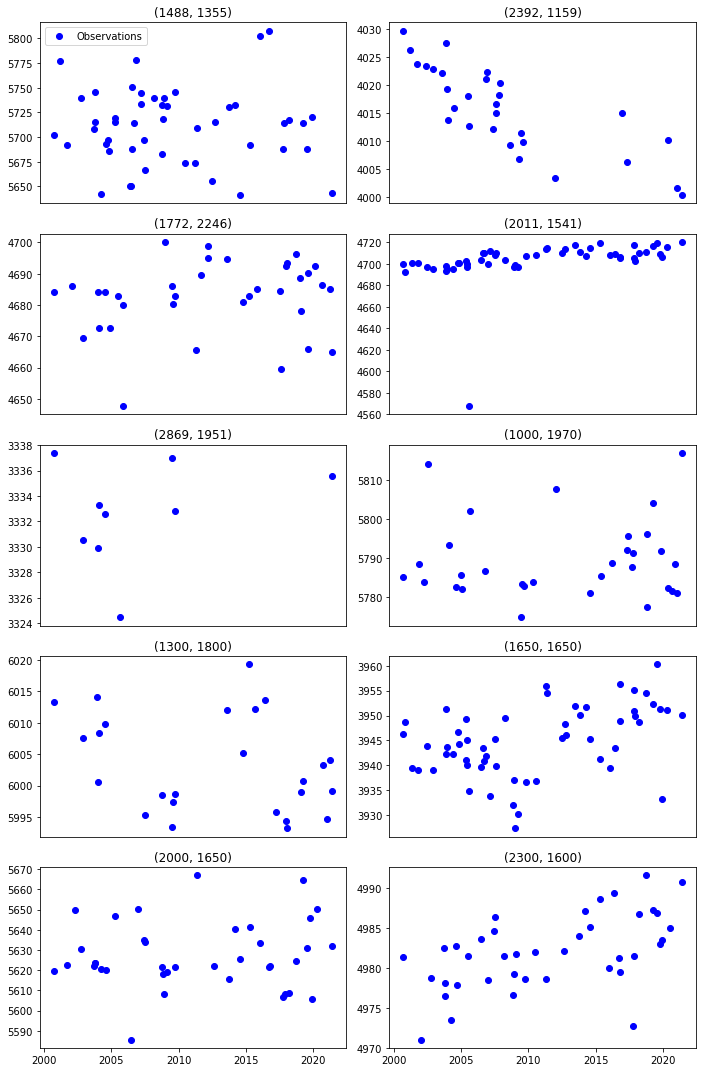

In [16]:
plotting.plot_time_series_gallery(X_train_data,y_train_data, labels = labels)

### Fit linear models

#### Prepare time series along which to make prediction

In [17]:
X = temporal.create_prediction_timeseries(start_date = '2000-01-01',
                                       end_date = '2023-01-01',
                                       dt ='M')

#### Linear regression

In [18]:
predictions = []

for i,v in enumerate(X_train_data):
    prediction, slope, intercept = temporal.linreg_predict(X_train_data[i],
                                      y_train_data[i],
                                      X,
                                      method='Linear')
    predictions.append(prediction)
    
LinearReg_df = pd.DataFrame(predictions).T
LinearReg_df.index = X

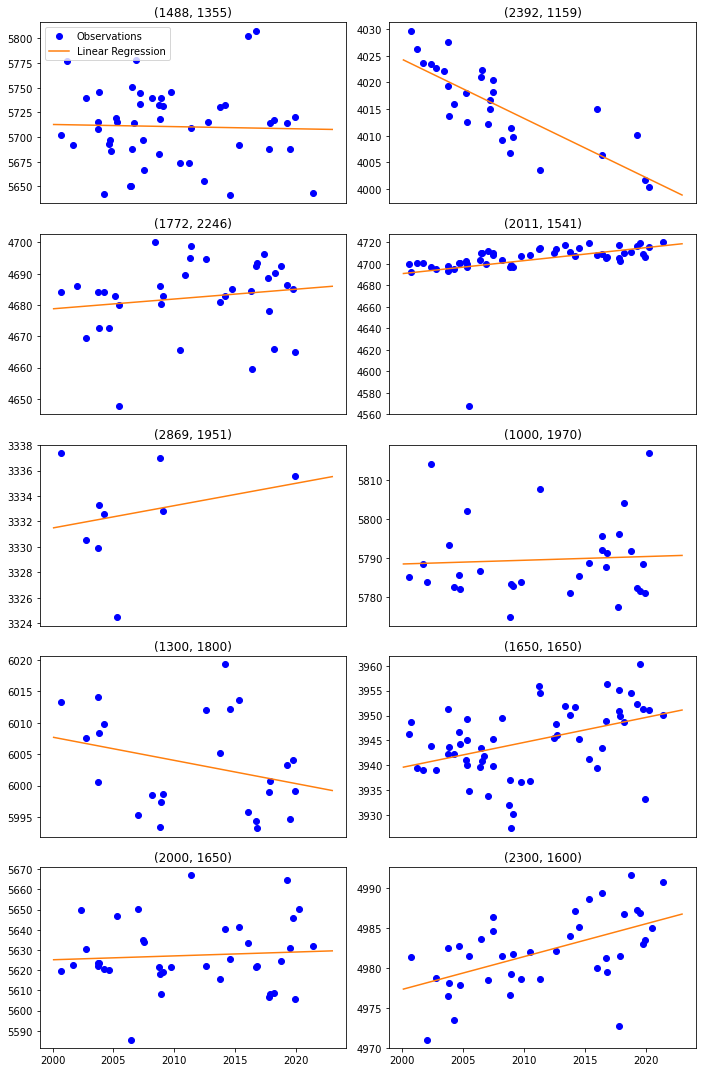

In [19]:
plotting.plot_time_series_gallery(X_train_data,
                                  y_train_data,
                                  predictions_df_list=[LinearReg_df,],
                                  legend_labels = ["Observations","Linear Regression"], 
                                  labels = labels)

#### RANSAC

In [20]:
predictions = []

for i,v in enumerate(X_train_data):
    prediction, slope, intercept = temporal.linreg_predict(X_train_data[i],
                                         y_train_data[i],
                                      X,
                                      method='RANSAC')
    predictions.append(prediction)
    
RANSAC_df = pd.DataFrame(predictions).T
RANSAC_df.index = X

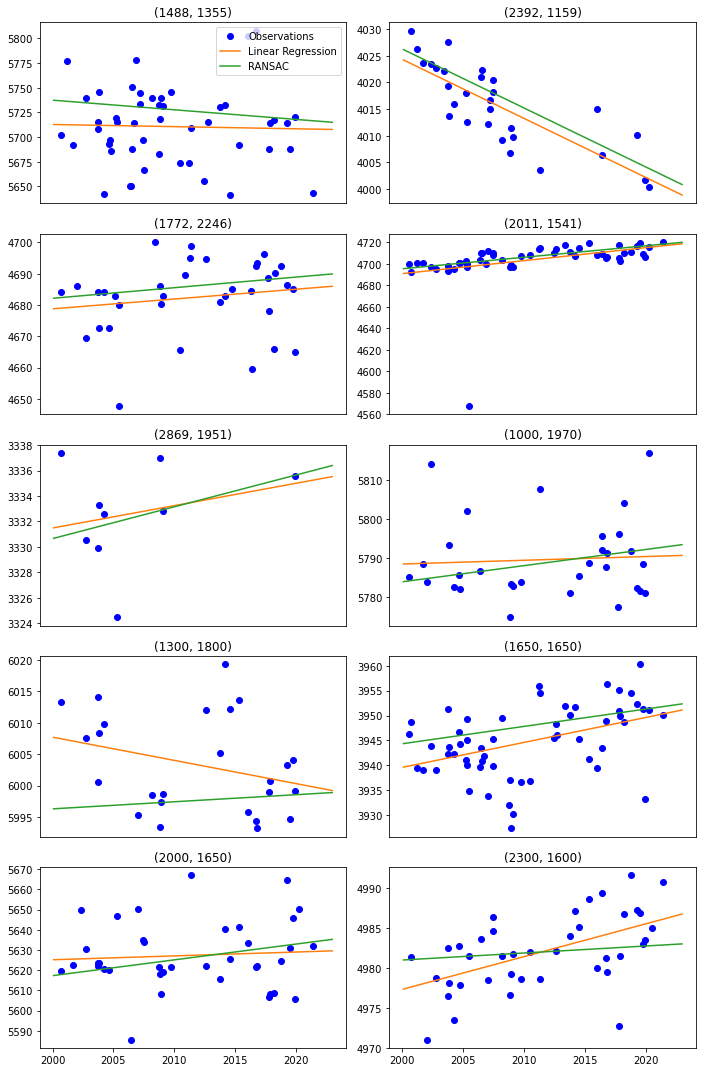

In [21]:
plotting.plot_time_series_gallery(X_train_data,
                                  y_train_data,
                                  predictions_df_list=[LinearReg_df,RANSAC_df],
                                  legend_labels = ["Observations",
                                                "Linear Regression",
                                                "RANSAC"], 
                                  labels = labels)

#### Theil Sen

In [22]:
predictions = []

for i,v in enumerate(X_train_data):
    prediction, slope, intercept = temporal.linreg_predict(X_train_data[i],
                                      y_train_data[i],
                                      X,
                                      method='TheilSen')
    predictions.append(prediction)
    
TheilSen_df = pd.DataFrame(predictions).T
TheilSen_df.index = X

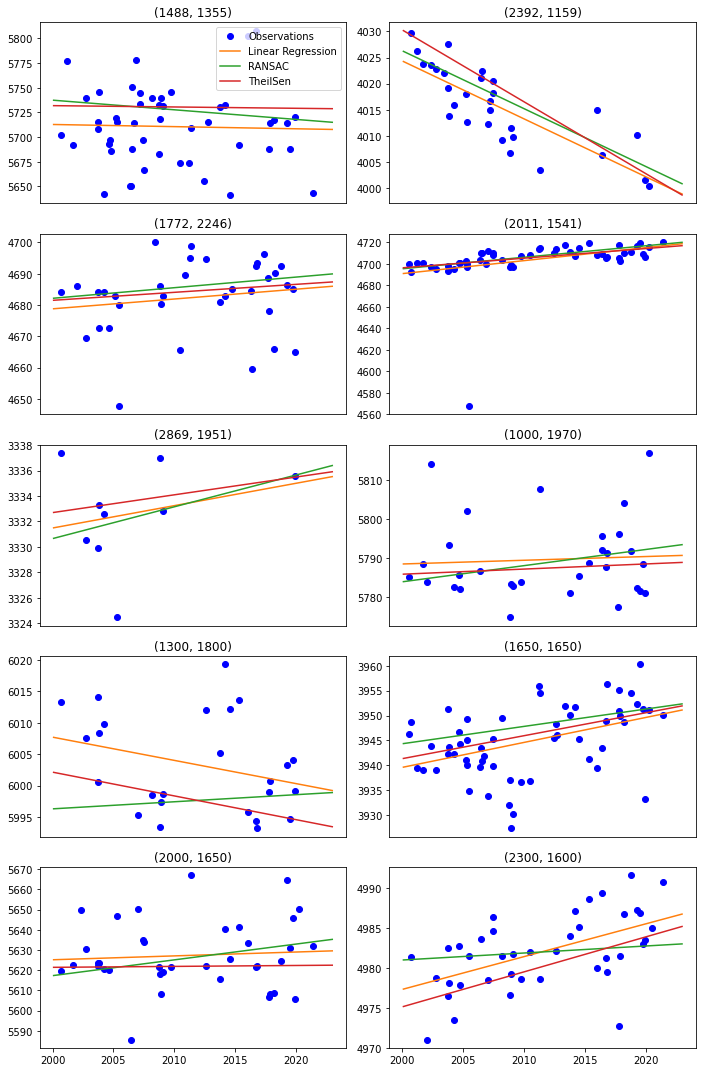

In [23]:
plotting.plot_time_series_gallery(X_train_data,
                                  y_train_data,
                                  predictions_df_list=[LinearReg_df,RANSAC_df,TheilSen_df],
                                  legend_labels = ["Observations",
                                                   "Linear Regression",
                                                   "RANSAC",
                                                   "TheilSen"], 
                                  labels = labels)

### Gaussian Process Regression
- Kernel adapted from [Mauna Loa](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py) example
- [Example adding error](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py)
- Need to design more custom kernel as was done in [Hugonnet et al. 2021](https://github.com/iamdonovan/pyddem/blob/master/pyddem/fit_tools.py#L1054)
- May be possible to use an automated approach to design the kernel
 - Decompase dominant modes and iteratively evaluate performance on kernels attempting to capture each mode.


In [24]:
predictions = []
std_predictions = []

for i,v in enumerate(X_train_data):
    gaussian_process_model = temporal.GPR_model(X_train_data[i], y_train_data[i], alpha=1e-10)
    mean_prediction, std_prediction = temporal.GPR_predict(gaussian_process_model, X)
    predictions.append(mean_prediction)
    std_predictions.append(std_prediction)
    
GPR_df = pd.DataFrame(predictions).T
GPR_df.index = X

GPR_std_df = pd.DataFrame(std_predictions).T
GPR_std_df.index = X

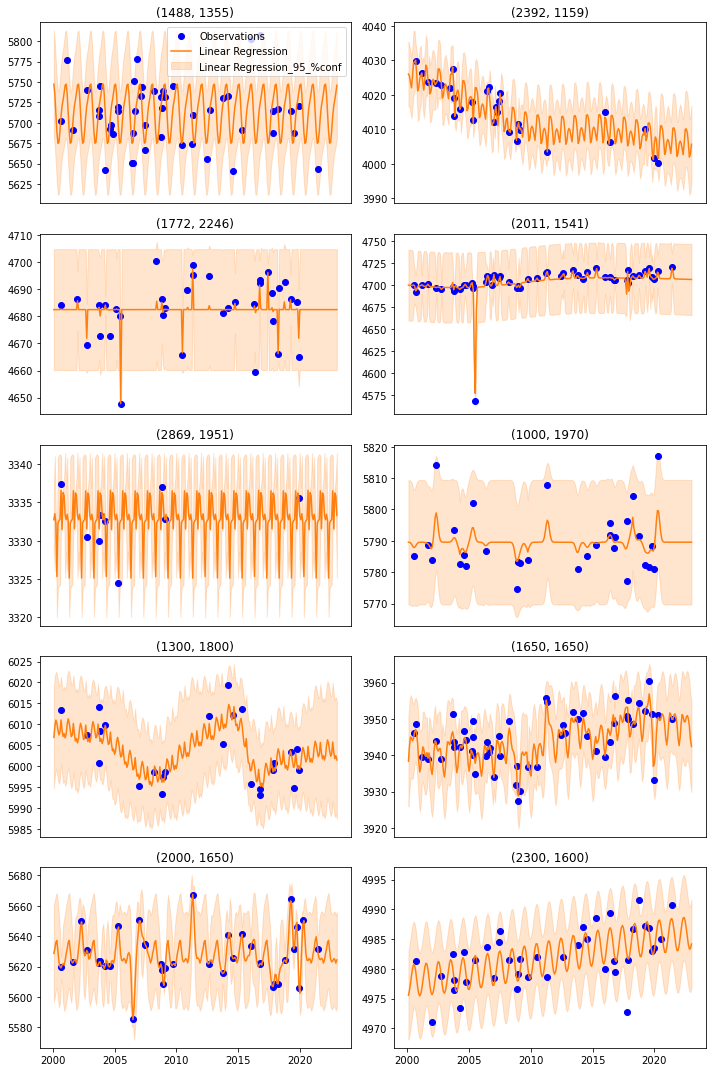

In [25]:
plotting.plot_time_series_gallery(X_train_data,
                                  y_train_data,
                                  predictions_df_list=[GPR_df],
                                  std_df_list=[GPR_std_df],
                                  legend_labels = ["Observations",
                                                "Linear Regression",
                                                "RANSAC",
                                                "TheilSen",
                                                "GPR"], 
                                  labels = labels)

### Multiprocessing linear regression
- slice the stack for testing

In [26]:
X_train = np.ma.array([utils.date_time_to_decyear(i) for i in datetimes_list]).data
test_stack = ma_stack[:,1500:1550,1700:1750]

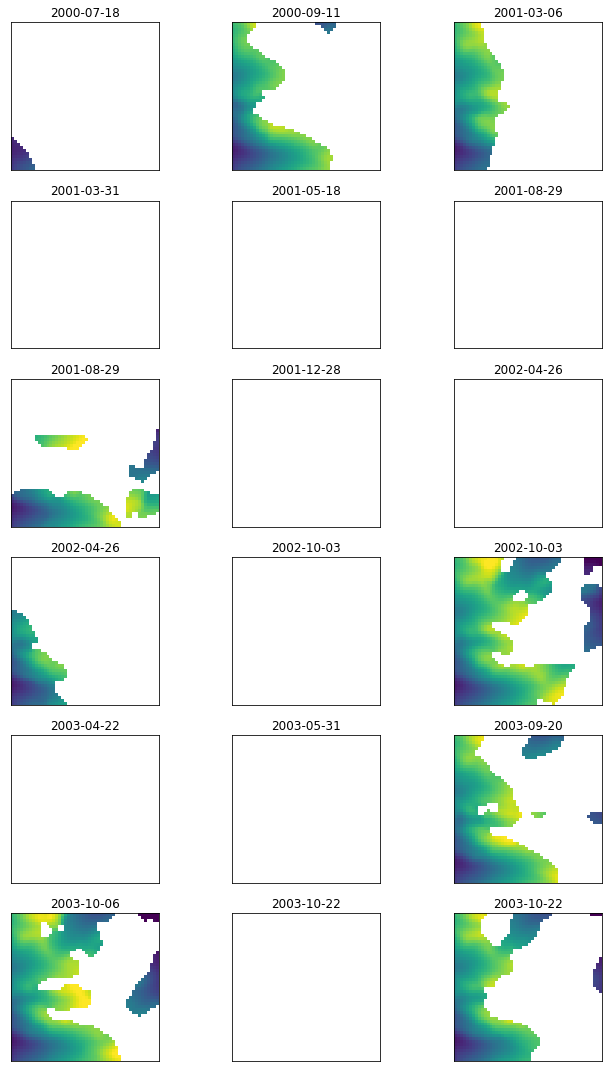

In [27]:
n = 18
plotting.plot_array_gallery(test_stack[:n], dates_list[:n])

#### Get pixel with 3 or more observations

In [28]:
valid_data, valid_mask_2D = temporal.mask_low_count_pixels(test_stack, n_thresh = 3)

#### Run linear model

In [29]:
results = temporal.linreg_run_parallel(X_train, valid_data, X, method='Linear')
prediction_stack = temporal.linreg_reshape_parallel_results(results, test_stack, valid_mask_2D)

#### Get labels for predictions dates

In [30]:
X_dates = [utils.decyear_to_date_time(i).date() for i in X]

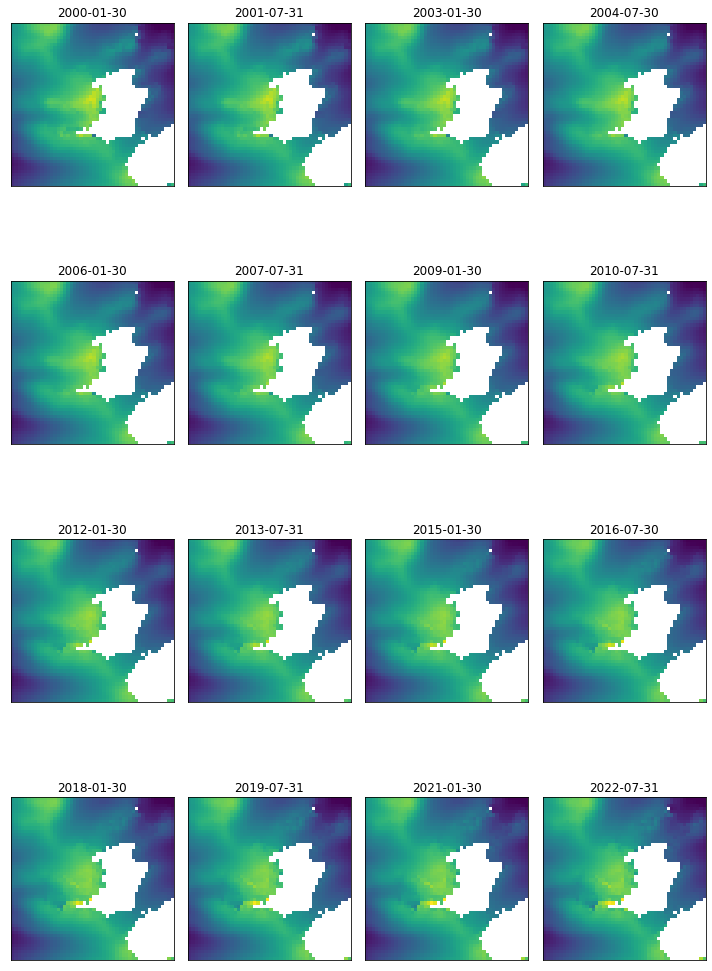

In [31]:
step = 20
plotting.plot_array_gallery(prediction_stack[::n], X_dates[::n])

In [32]:
# plotting.plot_timelapse(prediction_stack[::n], 
#                      titles_list=X_dates[::n])

### Multiprocessing GPR
- slice the stack for testing
- this is slow
- potentiall faster implementation [here](https://github.com/zgbkdlm/ssdgp/blob/main/python_notebooks/ssdgp_matern_32_ekfs_tutorial.ipynb) and [here](https://github.com/iamdonovan/pyddem/blob/master/pyddem/fit_tools.py#L1054)

In [33]:
valid_data, valid_mask_2D = temporal.mask_low_count_pixels(test_stack, n_thresh = 3)

In [125]:
%%time
results = temporal.GPR_run_parallel(X_train, valid_data, X, method='Linear')

In [123]:
prediction_stack = temporal.GPR_reshape_parallel_results(results, test_stack, valid_mask_2D)

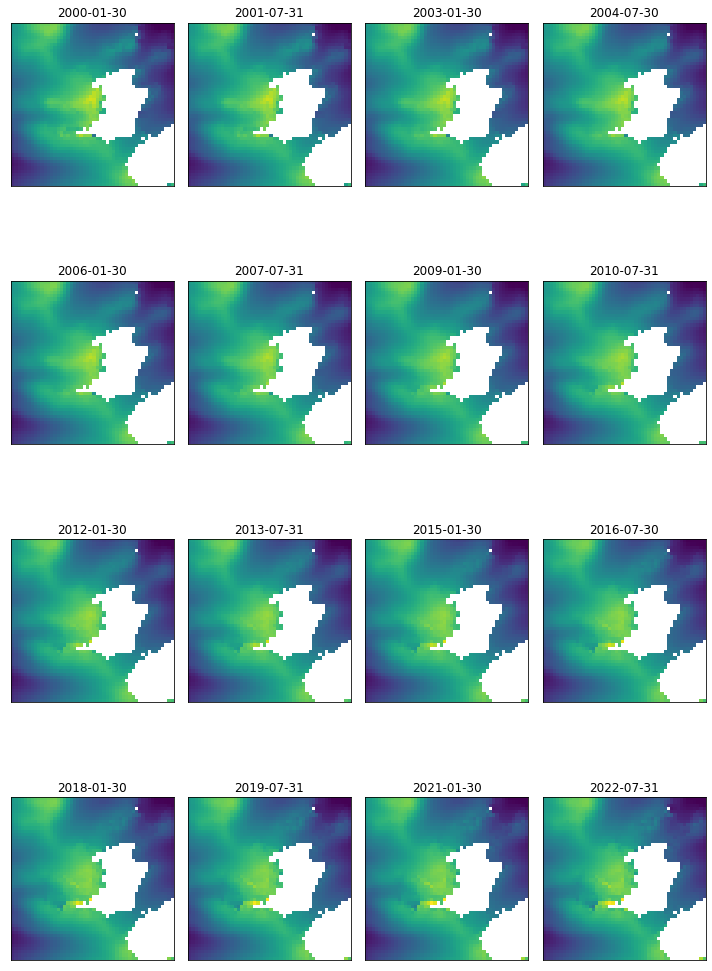

In [124]:
step = 20
plotting.plot_array_gallery(prediction_stack[::n], X_dates[::n])

In [90]:
# plotting.plot_timelapse(prediction_stack[::n], 
#                      titles_list=X_dates[::n])